<a href="https://colab.research.google.com/github/rich-hyun/Kuggle_9th_team_SAMTARBUCKS/blob/main/jaehyunkim_NVL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#데이터 가져오기

In [22]:
!pip install transformers
!pip install wordcloud
!pip install pandas textblob

In [23]:
#사용할 코드 import 하기
import os
import pandas as pd
import numpy as np
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from transformers import pipeline
from datetime import datetime
from calendar import calendar
from textblob import TextBlob
from calendar import month_name
import calendar
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# 데이터 로딩
df = pd.read_csv('https://raw.githubusercontent.com/rich-hyun/Kuggle_9th_team_/main/reviews_data.csv', encoding='utf-8')

# 'Date' 열에서 월, 일, 연도 추출
df['mnth'] = df['Date'].str.extract(r'Reviewed\s+([A-Za-z]+)')
df['day'] = df['Date'].str.extract(r'(\d{1,2}),').astype(int)
df['year'] = df['Date'].str.extract(r'(\d{4})').astype(int)

# 월 이름을 숫자로 매핑
months_map = {
    'Jan': 1, 'Feb': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'Aug': 8, 'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
df['mnth_num'] = df['mnth'].map(months_map)

# 월 번호로 변환
month_mapping = {v: k for k,v in enumerate(calendar.month_name)}
df['month_num'] = df['mnth'].map(month_mapping)

# 요일 계산
df['day2'] = df.apply(lambda row: datetime.strptime(f"{row['year']}-{row['mnth_num']}-{row['day']}", '%Y-%m-%d').strftime('%A'), axis=1)

# 요일 숫자로 매핑
day_to_num = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['day2_num'] = df['day2'].map(day_to_num)

# 필요한 열만 선택
df = df[['name', 'location', 'Date', 'year', 'mnth_num', 'day', 'day2_num', 'Rating', 'Review']]

# 'Rating'이 NaN인 행만 df_no_rating에 저장합니다.
df_no_rating = df[df['Rating'].isna()]
df_no_rating.head()

,name,location,Date,year,mnth_num,day,day2_num,Rating,Review
700,James,"Kansas City, MO","Reviewed July 25, 2011",2011,7,25,0,NaN,I just wanted to amend my email the I sent to ...
701,James,"Kansas City, MO","Reviewed July 25, 2011",2011,7,25,0,NaN,"Recently, I have gone to your Starbucks at Bar..."
702,Mike,"Revere, ma","Reviewed June 26, 2011",2011,6,26,6,NaN,Upon my first visit to this location on my way...
703,Hughes,"Macclesfield, Other","Reviewed Jan. 13, 2011",2011,1,13,3,NaN,"Recently, British Royal Marines in Iraq wrote ..."
704,Sherrilynn,"Jenison, MI","Reviewed Jan. 4, 2011",2011,1,4,1,NaN,"On the way to catch our plane, we got a medium..."


In [5]:
# NaN이 있는 행 제거
df_cleaned = df.dropna(subset=['Rating', 'Review'])

# 결과 확인
df_cleaned.head()

,name,location,Date,year,mnth_num,day,day2_num,Rating,Review
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",2023,9,13,2,5.0,Amber and LaDonna at the Starbucks on Southwes...
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",2023,7,16,6,5.0,** at the Starbucks by the fire station on 436...
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",2023,7,5,2,5.0,I just wanted to go out of my way to recognize...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",2023,5,26,4,5.0,Me and my friend were at Starbucks and my card...
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",2023,1,22,6,5.0,I?셫 on this kick of drinking 5 cups of warm wa...


In [6]:
# 각 location의 개수를 카운트합니다.
location_counts = df_cleaned['location'].value_counts()

location_counts

New York, NY         11
Seattle, WA          10
Los Angeles, CA       9
Chicago, IL           7
Denver, CO            6
                     ..
Crescent City, CA     1
Del Mar, CA           1
Baltimore, MD         1
Villanova, PA         1
Beecher, IL           1
Name: location, Length: 536, dtype: int64

In [7]:
df_cleaned.isnull()

,name,location,Date,year,mnth_num,day,day2_num,Rating,Review
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
696,False,False,False,False,False,False,False,False,False
697,False,False,False,False,False,False,False,False,False
698,False,False,False,False,False,False,False,False,False
699,False,False,False,False,False,False,False,False,False


#날짜 기반 rating 예측

In [ ]:
# 범주형 열 인코딩
label_encoders = {}
categorical_columns = ['year', 'mnth_num', 'day', 'day2_num']
for col in categorical_columns:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le

# 특성과 타겟 분리
X = df_cleaned[['year', 'mnth_num', 'day', 'day2_num']]
y = df_cleaned['Rating']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 훈련 및 평가 함수 정의
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return r2, rmse

# 다양한 모델로 예측 및 평가 수행
models = {
    'Linear Regression': LinearRegression(),
    'LightGBM': LGBMRegressor(verbose=-1),
    'XGBoost': XGBRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'Random Forest': RandomForestRegressor()
}

results = {}
for model_name, model in models.items():
    r2, rmse = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
    results[model_name] = {'R-squared': r2, 'RMSE': rmse}

# 결과 출력
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"R-squared: {metrics['R-squared']:.4f}")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print()

<ipython-input-18-a88f3d122058>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = le.fit_transform(df_cleaned[col])
<ipython-input-18-a88f3d122058>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[col] = le.fit_transform(df_cleaned[col])
<ipython-input-18-a88f3d122058>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

Linear Regression:
R-squared: 0.0065
RMSE: 1.3837

LightGBM:
R-squared: 0.1005
RMSE: 1.3166

XGBoost:
R-squared: -0.0534
RMSE: 1.4247

AdaBoost:
R-squared: 0.0804
RMSE: 1.3312

Random Forest:
R-squared: 0.1032
RMSE: 1.3145



#textblob 방식

In [ ]:
# NLTK 리소스 다운로드 (불용어, 토크나이저)
nltk.download('punkt')
nltk.download('stopwords')

# 텍스트 정규화: 소문자 변환
df_cleaned['Review'] = df_cleaned['Review'].str.lower()

# 토큰화: 각 리뷰를 개별 단어로 분리
df_cleaned['tokens'] = df_cleaned['Review'].apply(word_tokenize)

# 불용어 리스트 로드
stop_words = set(stopwords.words('english'))

# 불용어 제거
df_cleaned['tokens'] = df_cleaned['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# 어간 추출기 초기화
stemmer = SnowballStemmer('english')

# 어간 추출
df_cleaned['stemmed'] = df_cleaned['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# 결과 확인
df_cleaned[['Review', 'tokens', 'stemmed']].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-8-d0591318861a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Review'] = df_cleaned['Review'].str.lower()
<ipython-input-8-d0591318861a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['tokens'] = df_cleaned['Review'].apply(word_tokenize)
<ipython-input

,Review,tokens,stemmed
0,amber and ladonna at the starbucks on southwes...,"[amber, ladonna, starbucks, southwest, parkway...","[amber, ladonna, starbuck, southwest, parkway,..."
1,** at the starbucks by the fire station on 436...,"[*, *, starbucks, fire, station, 436, altamont...","[*, *, starbuck, fire, station, 436, altamont,..."
2,i just wanted to go out of my way to recognize...,"[wanted, go, way, recognize, starbucks, employ...","[want, go, way, recogn, starbuck, employe, bil..."
3,me and my friend were at starbucks and my card...,"[friend, starbucks, card, ?, 셳, work, ., thank...","[friend, starbuck, card, ?, 셳, work, ., thank,..."
4,i?셫 on this kick of drinking 5 cups of warm wa...,"[?, 셫, kick, drinking, 5, cups, warm, water, ....","[?, 셫, kick, drink, 5, cup, warm, water, ., wo..."


In [ ]:
# 감정 및 주관성 분석을 위한 함수 정의
def analyze_sentiment(text):
    # TextBlob 객체 생성
    analysis = TextBlob(text)
    # 감정(polarity)과 주관성(subjectivity) 반환
    return analysis.sentiment

# 'Review' 컬럼에 대해 감정 및 주관성 분석 수행
df_cleaned['sentiment'] = df_cleaned['Review'].apply(lambda x: analyze_sentiment(x))

# 결과 확인
df_cleaned[['Review', 'sentiment']].head()

<ipython-input-9-e674922a9842>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['sentiment'] = df_cleaned['Review'].apply(lambda x: analyze_sentiment(x))


,Review,sentiment
0,amber and ladonna at the starbucks on southwes...,"(0.3408163265306122, 0.3336734693877551)"
1,** at the starbucks by the fire station on 436...,"(0.2893939393939394, 0.6780303030303031)"
2,i just wanted to go out of my way to recognize...,"(-0.060714285714285686, 0.5666666666666667)"
3,me and my friend were at starbucks and my card...,"(0.26375, 0.44375)"
4,i?셫 on this kick of drinking 5 cups of warm wa...,"(0.3569047619047619, 0.6002380952380952)"


In [ ]:
# TextBlob을 사용하여 감정(polarity)과 주관성(subjectivity) 점수 계산
df_cleaned['Polarity'] = df_cleaned['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_cleaned['Subjectivity'] = df_cleaned['Review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# 감정 점수를 기반으로 레이블 생성
df_cleaned['Label'] = df_cleaned['Polarity'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# 레이블 생성
def label_sentiment(row):
    if row['Polarity'] > 0:
        return 'positive'
    elif row['Polarity'] < 0:
        return 'negative'
    else:
        return 'neutral'

df_cleaned['Label'] = df_cleaned.apply(label_sentiment, axis=1)

label_counts = df_cleaned['Label'].value_counts()
label_counts

<ipython-input-10-8f8864d79cb8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Polarity'] = df_cleaned['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
<ipython-input-10-8f8864d79cb8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Subjectivity'] = df_cleaned['Review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
<ipython-input-10-8f8864d79cb8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

positive    379
negative    301
neutral      21
Name: Label, dtype: int64

In [ ]:
# 피처 엔지니어링 - TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df_cleaned['Review'])
y = df_cleaned['Label']

# 토큰화 및 패딩 - LSTM을 위한 준비
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_cleaned['Review'])
X_seq = tokenizer.texts_to_sequences(df_cleaned['Review'])
X_pad = pad_sequences(X_seq, maxlen=100)

# 레이블 인코딩 - LSTM을 위한 준비
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

# 데이터 분할 - TF-IDF 기반 모델
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# 데이터 분할 - LSTM 모델
X_train_lstm, X_test_lstm, y_train_enc, y_test_enc = train_test_split(X_pad, y_enc, test_size=0.2, random_state=42)

# 모델 선택 및 훈련
models = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'LightGBM': LGBMClassifier(verbose=-1)
}

# 각 모델에 대한 훈련 및 성능 평가 - TF-IDF 기반 모델
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    predictions = model.predict(X_test_tfidf)
    print(f"Model: {name}")
    print(classification_report(y_test, predictions))

# LSTM 모델 정의
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=100, input_length=100))
lstm_model.add(LSTM(units=128))
lstm_model.add(Dense(3, activation='softmax'))  # 3개의 출력 클래스

# LSTM 모델 컴파일
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# LSTM 모델 훈련
lstm_model.fit(X_train_lstm, y_train_enc, epochs=5, batch_size=64)

# LSTM 모델 성능 평가
loss, accuracy = lstm_model.evaluate(X_test_lstm, y_test_enc)
print(f'LSTM model accuracy: {accuracy}')

Model: Logistic Regression
              precision    recall  f1-score   support

    negative       0.64      0.43      0.51        65
     neutral       0.00      0.00      0.00         4
    positive       0.60      0.81      0.69        72

    accuracy                           0.61       141
   macro avg       0.41      0.41      0.40       141
weighted avg       0.60      0.61      0.59       141



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Support Vector Machine
              precision    recall  f1-score   support

    negative       0.65      0.34      0.44        65
     neutral       0.00      0.00      0.00         4
    positive       0.58      0.86      0.69        72

    accuracy                           0.60       141
   macro avg       0.41      0.40      0.38       141
weighted avg       0.59      0.60      0.56       141



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Random Forest
              precision    recall  f1-score   support

    negative       0.65      0.48      0.55        65
     neutral       0.00      0.00      0.00         4
    positive       0.60      0.78      0.68        72

    accuracy                           0.62       141
   macro avg       0.42      0.42      0.41       141
weighted avg       0.61      0.62      0.60       141



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: Gradient Boosting
              precision    recall  f1-score   support

    negative       0.71      0.63      0.67        65
     neutral       0.00      0.00      0.00         4
    positive       0.68      0.76      0.72        72

    accuracy                           0.68       141
   macro avg       0.46      0.46      0.46       141
weighted avg       0.67      0.68      0.67       141

Model: LightGBM
              precision    recall  f1-score   support

    negative       0.68      0.66      0.67        65
     neutral       0.00      0.00      0.00         4
    positive       0.69      0.75      0.72        72

    accuracy                           0.69       141
   macro avg       0.46      0.47      0.46       141
weighted avg       0.67      0.69      0.68       141



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5
9/9 [==============================] - 8s 430ms/step - loss: 1.0468 - accuracy: 0.5107
Epoch 2/5
9/9 [==============================] - 4s 414ms/step - loss: 0.8049 - accuracy: 0.5518
Epoch 3/5
9/9 [==============================] - 3s 335ms/step - loss: 0.7643 - accuracy: 0.5518
Epoch 4/5
9/9 [==============================] - 2s 227ms/step - loss: 0.7296 - accuracy: 0.5571
Epoch 5/5
5/5 [==============================] - 1s 43ms/step - loss: 0.7641 - accuracy: 0.5248
LSTM model accuracy: 0.5248227119445801


In [ ]:
# 로지스틱 회귀 하이퍼파라미터 그리드
lr_params = {
    'C': [0.1, 1, 10],
    'max_iter': [100, 200]
}

# 서포트 벡터 머신 하이퍼파라미터 그리드
svc_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# 랜덤 포레스트 하이퍼파라미터 그리드
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

# 그래디언트 부스팅 하이퍼파라미터 그리드
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}

# LightGBM 하이퍼파라미터 그리드
lgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 62, 127],
    'boosting_type': ['gbdt', 'dart']
}

# 모델별 그리드 탐색 설정
model_params = {
    'Logistic Regression': (LogisticRegression(), lr_params),
    'Support Vector Machine': (SVC(), svc_params),
    'Random Forest': (RandomForestClassifier(), rf_params),
    'Gradient Boosting': (GradientBoostingClassifier(), gb_params),
    'LightGBM': (LGBMClassifier(verbose=-1), lgb_params)
}

# 각 모델에 대한 그리드 탐색 수행
for model_name, (model, params) in model_params.items():
    gs = GridSearchCV(model, params, cv=3, n_jobs=-1, verbose=1)
    gs.fit(X_train_tfidf, y_train)
    print(f"{model_name} best params: {gs.best_params_}")
    print(f"{model_name} best score: {gs.best_score_}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Logistic Regression best params: {'C': 1, 'max_iter': 100}
Logistic Regression best score: 0.6660916566039905
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Support Vector Machine best params: {'C': 10, 'kernel': 'rbf'}
Support Vector Machine best score: 0.6660724896019014
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Random Forest best params: {'max_depth': 20, 'n_estimators': 100}
Random Forest best score: 0.6607632300231921
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Gradient Boosting best params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
Gradient Boosting best score: 0.6857474172464686
Fitting 3 folds for each of 54 candidates, totalling 162 fits
LightGBM best params: {'boosting_type': 'dart', 'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 31}
LightGBM best score: 0.6340540126118873


In [ ]:
# 피처 엔지니어링 - TF-IDF
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df_cleaned['Review'])
y = df_cleaned['Label']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# 최적의 하이퍼파라미터를 사용하여 모델 생성 및 훈련
logreg_model = LogisticRegression(C=1, max_iter=100)
logreg_model.fit(X_train, y_train)

svm_model = SVC(C=10, kernel='rbf')
svm_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(max_depth=None, n_estimators=200)
rf_model.fit(X_train, y_train)

gb_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=10, n_estimators=200)
gb_model.fit(X_train, y_train)

lgbm_model = LGBMClassifier(boosting_type='dart', learning_rate=0.01, n_estimators=200, num_leaves=31, verbose=-1)
lgbm_model.fit(X_train, y_train)

# 모델 평가
logreg_pred = logreg_model.predict(X_test)
print(f"Logistic Regression Classification Report:\n{classification_report(y_test, logreg_pred)}")

svm_pred = svm_model.predict(X_test)
print(f"Support Vector Machine Classification Report:\n{classification_report(y_test, svm_pred)}")

rf_pred = rf_model.predict(X_test)
print(f"Random Forest Classification Report:\n{classification_report(y_test, rf_pred)}")

gb_pred = gb_model.predict(X_test)
print(f"Gradient Boosting Classification Report:\n{classification_report(y_test, gb_pred)}")

lgbm_pred = lgbm_model.predict(X_test)
print(f"LightGBM Classification Report:\n{classification_report(y_test, lgbm_pred)}")

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    negative       0.64      0.43      0.51        65
     neutral       0.00      0.00      0.00         4
    positive       0.60      0.81      0.69        72

    accuracy                           0.61       141
   macro avg       0.41      0.41      0.40       141
weighted avg       0.60      0.61      0.59       141

Support Vector Machine Classification Report:
              precision    recall  f1-score   support

    negative       0.65      0.48      0.55        65
     neutral       0.00      0.00      0.00         4
    positive       0.62      0.81      0.70        72

    accuracy                           0.63       141
   macro avg       0.42      0.43      0.42       141
weighted avg       0.62      0.63      0.61       141

Random Forest Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.49      0.59        65
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

#hugging face 방식

In [ ]:
# 여기서는 DistilBERT 모델을 사용
sentiment_pipeline = pipeline("sentiment-analysis")

def analyze_sentiment_hf(review):
    result = sentiment_pipeline(review)
    return result[0]['label'], result[0]['score']

# df_cleaned 데이터프레임이 정의되어 있다고 가정하고, 'Review' 열에 감정 분석 적용
# 결과는 'Sentiment'과 'Confidence'라는 두 개의 새로운 열에 저장
df_cleaned['Sentiment'], df_cleaned['Confidence'] = zip(*df_cleaned['Review'].map(analyze_sentiment_hf))

# 결과 확인
df_cleaned[['Review', 'Sentiment', 'Confidence']].head()

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


<ipython-input-14-ebf7a3a46a03>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Sentiment'], df_cleaned['Confidence'] = zip(*df_cleaned['Review'].map(analyze_sentiment_hf))
<ipython-input-14-ebf7a3a46a03>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Sentiment'], df_cleaned['Confidence'] = zip(*df_cleaned['Review'].map(analyze_sentiment_hf))


,Review,Sentiment,Confidence
0,amber and ladonna at the starbucks on southwes...,POSITIVE,0.999854
1,** at the starbucks by the fire station on 436...,POSITIVE,0.998703
2,i just wanted to go out of my way to recognize...,NEGATIVE,0.996533
3,me and my friend were at starbucks and my card...,NEGATIVE,0.868515
4,i?셫 on this kick of drinking 5 cups of warm wa...,POSITIVE,0.999205


In [ ]:
# 1부터 0.9 사이의 신뢰도 점수를 가진 개수를 카운트합니다.
confidence_high_count = df_cleaned[df_cleaned['Confidence'] > 0.9].shape[0]

# 나머지 신뢰도 점수를 가진 개수를 카운트합니다.
confidence_other_count = df_cleaned[df_cleaned['Confidence'] <= 0.9].shape[0]

# 결과를 출력합니다.
(confidence_high_count, confidence_other_count)

(677, 24)

In [ ]:
# 신뢰도 점수가 0.9 이하인 리뷰를 삭제합니다.
df_cleaned_high_confidence = df_cleaned[df_cleaned['Confidence'] > 0.9]

# 신뢰도가 높은 리뷰의 데이터프레임에서 'Sentiment' 열의 값에 따라 positive와 negative의 개수를 카운트합니다.
positive_count = df_cleaned_high_confidence[df_cleaned_high_confidence['Sentiment'] == 'POSITIVE'].shape[0]
negative_count = df_cleaned_high_confidence[df_cleaned_high_confidence['Sentiment'] == 'NEGATIVE'].shape[0]

# 결과를 출력합니다.
(positive_count, negative_count)

(122, 555)

In [ ]:
# 데이터 준비
X = df_cleaned['Review']  # 감정 분석을 할 텍스트 데이터
y = df_cleaned['Sentiment']  # 감정 레이블

# 레이블 인코딩
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 텍스트 데이터를 수치 데이터로 변환
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# 데이터 타입 문제를 방지하기 위해 float 타입으로 변환
X_vectorized = X_vectorized.astype('float32')

# 훈련 세트와 테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.2, random_state=42)

# 모델들의 결과를 저장할 딕셔너리
model_results = {}

# 1. 로지스틱 회귀(Logistic Regression)
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
model_results['LogisticRegression'] = lr_model.score(X_test, y_test)

# 2. 서포트 벡터 머신(SVM)
svm_model = SVC()
svm_model.fit(X_train, y_train)
model_results['SVM'] = svm_model.score(X_test, y_test)

# 3. 랜덤 포레스트(Random Forest)
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
model_results['RandomForest'] = rf_model.score(X_test, y_test)

# 4. XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
model_results['XGBoost'] = xgb_model.score(X_test, y_test)

# 5. LightGBM
lgbm_model = LGBMClassifier(verbose=-1)
lgbm_model.fit(X_train, y_train)
model_results['LightGBM'] = lgbm_model.score(X_test, y_test)

# 6. AdaBoost
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)
model_results['AdaBoost'] = ada_model.score(X_test, y_test)

# 모델 결과 반환
model_results

{'LogisticRegression': 0.8723404255319149,
 'SVM': 0.8297872340425532,
 'RandomForest': 0.8368794326241135,
 'XGBoost': 0.900709219858156,
 'LightGBM': 0.8723404255319149,
 'AdaBoost': 0.8723404255319149}

In [ ]:
# 데이터 준비
X = df_cleaned['Review']
y = df_cleaned['Sentiment']

# 레이블 인코딩
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 텍스트 데이터를 수치 데이터로 변환
vectorizer = CountVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# 데이터 타입을 float32로 변환
X_vectorized = X_vectorized.astype('float32')

# 훈련 세트와 테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.2, random_state=42)

# 모델 훈련 및 성능 저장
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(verbose=-1),
    'AdaBoost': AdaBoostClassifier()
}

model_results = {}
class_accuracies = {}

for model_name, model in models.items():
    # 모델 훈련
    model.fit(X_train, y_train)
    # 테스트 데이터에 대한 정확도 저장
    model_results[model_name] = model.score(X_test, y_test)
    # 클래스별 정확도 계산
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    class_accuracies[model_name] = {
        'accuracy_positive': tp / (tp + fn),
        'accuracy_negative': tn / (tn + fp)
    }

# 모델별 전체 정확도 결과 출력
print(model_results)
# 모델별 클래스별 정확도 결과 출력
print(class_accuracies)

{'LogisticRegression': 0.8723404255319149, 'SVM': 0.8297872340425532, 'RandomForest': 0.8368794326241135, 'XGBoost': 0.900709219858156, 'LightGBM': 0.8723404255319149, 'AdaBoost': 0.8723404255319149}
{'LogisticRegression': {'accuracy_positive': 0.48, 'accuracy_negative': 0.9568965517241379}, 'SVM': {'accuracy_positive': 0.04, 'accuracy_negative': 1.0}, 'RandomForest': {'accuracy_positive': 0.08, 'accuracy_negative': 1.0}, 'XGBoost': {'accuracy_positive': 0.56, 'accuracy_negative': 0.9741379310344828}, 'LightGBM': {'accuracy_positive': 0.56, 'accuracy_negative': 0.9396551724137931}, 'AdaBoost': {'accuracy_positive': 0.56, 'accuracy_negative': 0.9396551724137931}}


In [ ]:
# 훈련 세트와 테스트 세트 분리
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.2, random_state=42)

# 모델과 하이퍼파라미터 그리드 설정
model_params = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l2']
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': [1, 0.1, 0.01],
            'kernel': ['rbf', 'linear']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(verbose=-1),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'num_leaves': [31, 50],
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1]
        }
    }
}

# 하이퍼파라미터 튜닝 실행과 결과 저장
tuned_models = {}
for model_name, mp in model_params.items():
    grid_search = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    tuned_models[model_name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_
    }

# 모델별 튜닝 결과 출력
for model_name, model_info in tuned_models.items():
    print(f"{model_name} best score: {model_info['best_score']}")
    print(f"{model_name} best params: {model_info['best_params']}")


LogisticRegression best score: 0.8910714285714285
LogisticRegression best params: {'C': 1, 'penalty': 'l2'}
SVM best score: 0.8785714285714284
SVM best params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
RandomForest best score: 0.8321428571428571
RandomForest best params: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 10}
XGBoost best score: 0.8625
XGBoost best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
LightGBM best score: 0.8660714285714286
LightGBM best params: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 31}
AdaBoost best score: 0.8482142857142856
AdaBoost best params: {'learning_rate': 0.1, 'n_estimators': 200}


In [ ]:
# 최적의 하이퍼파라미터를 사용하여 모델 생성 및 훈련
logreg_model = LogisticRegression(C=1, penalty='l2')
logreg_model.fit(X_train, y_train)

svm_model = SVC(C=10, gamma=0.01, kernel='rbf')
svm_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=10)
rf_model.fit(X_train, y_train)

xgb_model = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, verbosity=0)
xgb_model.fit(X_train, y_train)

lgbm_model = LGBMClassifier(learning_rate=0.1, n_estimators=200, num_leaves=31, verbose=-1)
lgbm_model.fit(X_train, y_train)

ada_model = AdaBoostClassifier(learning_rate=0.1, n_estimators=200)
ada_model.fit(X_train, y_train)

# 모델 평가
logreg_pred = logreg_model.predict(X_test)
print(f"Logistic Regression Classification Report:\n{classification_report(y_test, logreg_pred)}")

svm_pred = svm_model.predict(X_test)
print(f"SVM Classification Report:\n{classification_report(y_test, svm_pred)}")

rf_pred = rf_model.predict(X_test)
print(f"Random Forest Classification Report:\n{classification_report(y_test, rf_pred)}")

xgb_pred = xgb_model.predict(X_test)
print(f"XGBoost Classification Report:\n{classification_report(y_test, xgb_pred)}")

lgbm_pred = lgbm_model.predict(X_test)
print(f"LightGBM Classification Report:\n{classification_report(y_test, lgbm_pred)}")

ada_pred = ada_model.predict(X_test)
print(f"AdaBoost Classification Report:\n{classification_report(y_test, ada_pred)}")

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       116
           1       0.71      0.48      0.57        25

    accuracy                           0.87       141
   macro avg       0.80      0.72      0.75       141
weighted avg       0.86      0.87      0.86       141

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       116
           1       0.75      0.36      0.49        25

    accuracy                           0.87       141
   macro avg       0.81      0.67      0.70       141
weighted avg       0.85      0.87      0.85       141

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       116
           1       1.00      0.12      0.21        25

    accuracy                           0.84       141
   macro avg       0.

#리뷰 예측 모델

In [ ]:
# 데이터 로딩
df = pd.read_csv('https://raw.githubusercontent.com/rich-hyun/Kuggle_9th_team_/main/reviews_data.csv', encoding='utf-8')

# Rating과 Review가 모두 NaN이 아닌 데이터를 제외하고, Rating만 NaN인 데이터를 필터링합니다.
df_no_rating = df[df['Rating'].isna() & df['Review'].notna()]

# 'Rating'이 NaN이 아닌 데이터로 모델을 훈련시킬 데이터셋을 준비합니다.
df_with_rating = df.dropna(subset=['Rating'])

# Rating을 정수형으로 변환합니다.
df_with_rating['Rating'] = df_with_rating['Rating'].astype(int)

# 리뷰 텍스트를 기반으로 TF-IDF 벡터화를 수행합니다.
tfidf = TfidfVectorizer()
X_with_rating = tfidf.fit_transform(df_with_rating['Review'])

# 레이블 인코딩을 수행합니다.
le = LabelEncoder()
y_with_rating = le.fit_transform(df_with_rating['Rating'])

<ipython-input-23-b0263f723df0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_rating['Rating'] = df_with_rating['Rating'].astype(int)


In [ ]:
# 데이터를 훈련 세트와 테스트 세트로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X_with_rating, y_with_rating, test_size=0.2, random_state=42)

# XGBoost 모델을 최적의 하이퍼파라미터로 초기화하고 훈련합니다.
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)
xgb_model.fit(X_train, y_train)

# Rating이 NaN인 데이터에 대한 TF-IDF 변환
X_no_rating = tfidf.transform(df_no_rating['Review'])

# NaN인 Rating에 대한 예측
predicted_ratings = xgb_model.predict(X_no_rating)

# 예측된 Rating을 원래 데이터프레임에 추가합니다.
df_no_rating['Rating'] = predicted_ratings

# 예측된 Rating을 인코더를 이용해 원래 레이블로 변환합니다.
df_no_rating['Rating'] = le.inverse_transform(df_no_rating['Rating'])

<ipython-input-24-3f9e7ca6fcdd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_rating['Rating'] = predicted_ratings
<ipython-input-24-3f9e7ca6fcdd>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_rating['Rating'] = le.inverse_transform(df_no_rating['Rating'])


In [ ]:
# 예측된 Rating이 있는 행만 필터링하여 새 DataFrame에 저장합니다.
df_predicted_ratings = df_no_rating[df_no_rating['Rating'].notna()]

# 예측된 Rating을 가진 리뷰와 평점만 출력합니다.
df_predicted_ratings[['Review', 'Rating']].head()

,Review,Rating
700,I just wanted to amend my email the I sent to ...,1
701,"Recently, I have gone to your Starbucks at Bar...",1
702,Upon my first visit to this location on my way...,1
703,"Recently, British Royal Marines in Iraq wrote ...",1
704,"On the way to catch our plane, we got a medium...",1


In [ ]:
# 결과를 Excel 파일로 저장합니다.
df_predicted_ratings[['Review', 'Rating']].to_excel('predicted_ratings.xlsx', index=False)

In [ ]:
# 현재 작업 디렉토리 확인
current_directory = os.getcwd()
print("Current working directory:", current_directory)

# 현재 디렉토리의 파일 리스트 출력
files_in_directory = os.listdir(current_directory)
print("Files in the current directory:", files_in_directory)

Current working directory: /content
Files in the current directory: ['.config', 'predicted_ratings.xlsx', 'sample_data']


#감정을 나타내는 주요 키워드 추출

In [24]:
# df_cleaned 데이터프레임의 'Review' 열을 사용
reviews = df_cleaned['Review']

# 감정 키워드 추출
emotion_keywords = []
for review in reviews:
    blob = TextBlob(review)
    # pos_tag를 사용하여 형용사만 추출
    adjectives = [word for word, pos in blob.tags if pos in ('JJ', 'JJR', 'JJS')]
    emotion_keywords.extend(adjectives)

# 가장 흔한 10개의 형용사 찾기
most_common_emotions = Counter(emotion_keywords).most_common(10)

# 결과 출력
print(most_common_emotions)

[('good', 89), ('other', 86), ('same', 77), ('more', 67), ('great', 67), ('new', 63), ('free', 61), ('last', 54), ('hot', 50), ('different', 47)]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

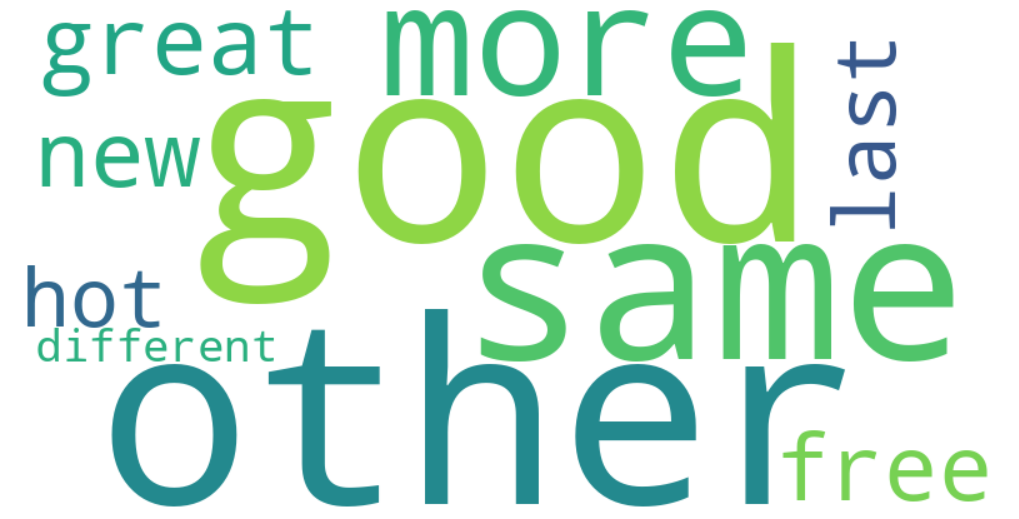

In [25]:
# 위에서 추출한 형용사와 그 빈도수를 딕셔너리로 변환합니다.
data = {
    'good': 89, 'other': 86, 'same': 77, 'more': 67, 'great': 67,
    'new': 63, 'free': 61, 'last': 54, 'hot': 50, 'different': 47
}

# 워드 클라우드 객체를 생성합니다.
wordcloud = WordCloud(width = 800, height = 400, background_color ='white')

# 빈도수를 기반으로 워드 클라우드를 생성합니다.
wordcloud.generate_from_frequencies(data)

# 생성된 워드 클라우드를 시각화합니다.
plt.figure(figsize = (10, 5), facecolor = None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)

# 이미지를 PNG 파일로 저장합니다.
plt.savefig("wordcloud.png", format="png")

# 저장된 이미지 파일을 다운로드합니다 (Colab 환경에서 실행하는 경우)
from google.colab import files
files.download("wordcloud.png")

# 이미지를 저장하거나 보여줍니다.
plt.show()